# 12.8.1 Computer Exercise 12.1: Huffman Code

The first program implements a Huffman encoder function. The user need only supply a probability vector that consists of all the source symbol probabilities. The probability entries do not need to be ordered.

<span style="color:red"> <b>*Note:  Refer to textbook for additional information. *</b></span>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Python function huffmancode defined here
def huffmancode(p):
    # input p is a probability vector of p(x_i) of source symbols x_i
    pord = np.argsort(p)
    psort = p[pord]
    n = len(p);    q = p.copy()
    m = [None] * (n - 1)

    for i in range(n - 1):
        l = np.argsort(q)
        q = q[l]
        m[i] = np.concatenate((l[:n-i], [-1] * i))
        q = np.concatenate(([q[0] + q[1]], q[2:], [1]))
    m = np.array(m)
    Cword = [''] * (n-1) + ['0'] + [''] * (n-1) + ['1']
    for i1 in range(n - 2):
        Ctemp = Cword.copy()
        idx0 = (np.where(m[(n-1) - (i1+1),:]==0)[0][0]+1) * n
        Cword[:n] = Ctemp[idx0 - n + 1:idx0] + ['0']
        Cword[n:2 * n - 1] = Cword[:n - 1] + ['1']
        for i2 in range(2, i1 + 3):
            idx2 = np.where(m[(n-1) - (i1+1),:]==i2-1)[0][0]+1
            Cword[i2 * n:(i2 + 1) * n] = Ctemp[n * (idx2 - 1):n * idx2]

    huffcode = [[''] * n for _ in range(n)]
    for i in range(n):
        idx1 = np.where(m[0,:]==i)[0][0]+1
        huffcode[i] = ''.join(Cword[n * (idx1 - 1):idx1 * n])
    return huffcode, n

In [5]:
# This exercise requires the input of a probability vector p that list all the
# probabilities of each source input symbol
p = np.array([0.2, 0.05, 0.03, 0.1, 0.3, 0.02, 0.22, 0.08]) #symbol probabilities

huffcode, n = huffmancode(p)  # Encode Huffman code
entropy = -np.sum(np.log2(p) * p)  # Find entropy of the source
# Display the results of Huffman encoder
print('symbol  -->\tcodeword\tProbability')
codeword_lengths = np.zeros(n, dtype=int)
for i in range(n):
    codeword = huffcode[i]
    codeword_lengths[i] = len(codeword)
    print(f'x{i+1}\t-->\t{codeword}\t\t{p[i]}')

print(f'Codeword lengths: {codeword_lengths}')
avg_length = np.dot(codeword_lengths, p)
print(f'Entropy = {entropy:.4f}')
print(f'Average codeword length = {avg_length:.4f}')

symbol  -->	codeword	Probability
x1	-->	00		0.2
x2	-->	10111		0.05
x3	-->	101101		0.03
x4	-->	100		0.1
x5	-->	11		0.3
x6	-->	101100		0.02
x7	-->	01		0.22
x8	-->	1010		0.08
Codeword lengths: [2 5 6 3 2 6 2 4]
Entropy = 2.5705
Average codeword length = 2.6100


# 12.8.2 Computer Exercise 12.2: Channel Capacity and Mutual Information
<span style="color:red"> <b>*Note: Note:  Refer to textbook for additional information.*</b></span>

In [6]:
def mutualinfo(x, y):
    '''Computes the mutual information of two vectors x and y in bits
    Args:
        x, y: the 1-D vectors to be analyzed.
    Returns:
        muinfo_bit: mutual information.'''
    minx = np.min(x); maxx = np.max(x)
    deltax = (maxx - minx) / (len(x) - 1)
    lowerx = minx - deltax / 2; upperx = maxx + deltax / 2
    ncellx = np.ceil(len(x) ** (1/3))
    miny = np.min(y); maxy = np.max(y)
    deltay = (maxy - miny) / (len(y) - 1)
    lowery = miny - deltay / 2; uppery = maxy + deltay / 2
    ncelly = ncellx

    rout = np.zeros((int(ncellx), int(ncelly)))
    xx = np.round(((x - lowerx) / (upperx - lowerx)) * ncellx + 1 / 2)
    yy = np.round(((y - lowery) / (uppery - lowery)) * ncelly + 1 / 2)

    for n in range(len(x)):
        indexx = int(xx[n])
        indexy = int(yy[n])
        if 1 <= indexx <= ncellx and 1 <= indexy <= ncelly:
            rout[indexx - 1, indexy - 1] += 1
    h = rout
    estimate = 0;    sigma = 0;    count = 0   # initialize to 0 before updating
    hy = np.sum(h, axis=0); hx = np.sum(h, axis=1) # Define row and column sums

    for nx in range(int(ncellx)):
        for ny in range(int(ncelly)):
            if h[nx, ny] != 0:
                logf = np.log(h[nx, ny] / hx[nx] / hy[ny])
            else:
                logf = 0
            count += h[nx, ny]
            estimate += h[nx, ny] * logf
            sigma += h[nx, ny] * logf ** 2
    # Biased estimate
    estimate /= count
    sigma = np.sqrt((sigma / count - estimate ** 2) / (count - 1))
    estimate += np.log(count)
    nbias = (ncellx - 1) * (ncelly - 1) / (2 * count)
    muinfo_bit = (estimate - nbias) / np.log(2)     # Remove bias
    return muinfo_bit

In [7]:
Channel_gain = 1   # User defined scalar channel gain
H = Channel_gain # AWGN Channel gain
SNRdb = np.arange(0, 25, 5) # SNR in dB
L = 200000
SNR = 10 ** (SNRdb / 10) # Compute the analytical channel capacity
Capacity = 1 / 2 * np.log2(1 + H * SNR)

# Estimate mutual information between input and output signals for AWGN channels
muinfovec = np.zeros((len(SNRdb), 5))
for kk in range(len(SNRdb)):
    noise = np.random.randn(L) / np.sqrt(SNR[kk])
    x = np.random.randn(L)
    x1 = np.sign(x)
    x2 = (np.floor(np.random.rand(L) * 4 - 4e-10) * 2 - 3) / np.sqrt(5)
    x3 = (np.floor(np.random.rand(L) * 8 - 4e-10) * 2 - 7) / np.sqrt(21)
    x4 = (np.random.rand(L) - 0.5) * np.sqrt(12)
    muinfovec[kk, 0] = mutualinfo(x, x + noise) # Gaussian input
    muinfovec[kk, 1] = mutualinfo(x1, x1 + noise) # Binary input (-1,+1)
    muinfovec[kk, 2] = mutualinfo(x2, x2 + noise) # 4-PAM input (-3,-1,1,3)
    muinfovec[kk, 3] = mutualinfo(x3, x3 + noise) # 8-PAM (-7,-5,-3,-1,1,3,5,7)
    muinfovec[kk, 4] = mutualinfo(x4, x4 + noise) # Uniform input(-0.5,0.5)

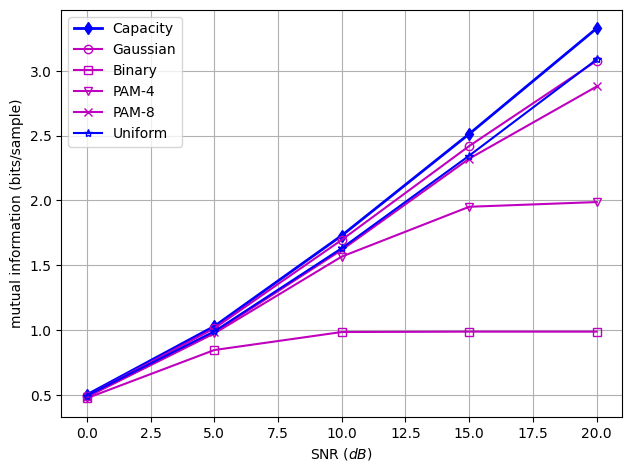

In [8]:
# plot capacity and mutual information
plt.plot(SNRdb,Capacity, 'b-d', label='Capacity',linewidth=2)
plt.plot(SNRdb,muinfovec[:,0],'m-o', label='Gaussian',mfc='none')
plt.plot(SNRdb,muinfovec[:,1],'m-s', label='Binary',mfc='none')
plt.plot(SNRdb,muinfovec[:,2],'m-v', label='PAM-4',mfc='none')
plt.plot(SNRdb,muinfovec[:,3],'m-x', label='PAM-8',mfc='none')
plt.plot(SNRdb,muinfovec[:,4],'b-*', label='Uniform',mfc='none')
plt.xlabel(r'SNR $(dB)$'); plt.ylabel('mutual information (bits/sample)')
plt.legend(loc='upper left'); plt.grid()
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig12_14.png" width="600" />

<center><b>Figure 12.14</b> Channel capacity compared with mutual information between channel output and different input signals.</center>

# 12.8.3 Computer Exercise 12.3: MIMO Channel Capacity
<span style="color:red"> <b>*Note:  Refer to textbook for additional information.*</b></span>

In [9]:
# This program calculates capacity of random MIMO (mxn) channels and plots the
# cumulative distribution (CDF) of the resulting capacity;
K = 500     # Number of random channels: K=200;
SNRdb = 3   # Signal to noise ratio: SNRdb=3dB
SNR = 10 ** (SNRdb / 10)    # convert SNRdb to real numeral

m = 1;  n = 1; cap11 = np.zeros(K)  # 1x1 channels
for kk in range(K):
    H = np.random.randn(m, n)  # Random MIMO Channel
    cap11[kk] = np.log(np.linalg.det(np.eye(n) + SNR * H.T @ H))/(2 * np.log(2))
[N11, C11]= np.histogram(cap11,bins=K // 10, density=False)  #CDF: MIMO capacity
C11 = C11[:-1] + np.diff(C11)/2

m = 2; n = 2; cap22 = np.zeros(K)   # 2x2 channels
for kk in range(K):
    H = np.random.randn(m, n)  # Random MIMO Channel
    cap22[kk] = np.log(np.linalg.det(np.eye(n) + SNR * H.T @ H))/(2 * np.log(2))
[N22, C22] = np.histogram(cap22,bins=K // 10, density=False) #CDF: MIMO capacity
C22 = C22[:-1] + np.diff(C22)/2

m = 4; n = 2; cap42 = np.zeros(K)   # 4x2 channels
for kk in range(K):
    H = np.random.randn(m, n)  # Random MIMO Channel
    cap42[kk] = np.log(np.linalg.det(np.eye(n) + SNR * H.T @ H))/(2 * np.log(2))
[N42, C42] = np.histogram(cap42,bins=K // 10, density=False) #CDF: MIMO capacity
C42 = C42[:-1] + np.diff(C42)/2

m = 2; n = 4; cap24 = np.zeros(K)  # 2x4 channels
for kk in range(K):
    H = np.random.randn(m, n)  # Random MIMO Channel
    cap24[kk] = np.log(np.linalg.det(np.eye(n) + SNR * H.T @ H))/(2 * np.log(2))
[N24, C24] = np.histogram(cap24,bins=K // 10, density=False) #CDF: MIMO capacity
C24 = C24[:-1] + np.diff(C24)/2

m = 4;  n = 4; cap44 = np.zeros(K)  # 4x4 channels
for kk in range(K):
    H = np.random.randn(m, n)  # Random MIMO Channel
    cap44[kk] = np.log(np.linalg.det(np.eye(n) + SNR * H.T @ H))/(2 * np.log(2))
[N44, C44] = np.histogram(cap44,bins=K // 10, density=False) #CDF: MIMO capacity
C44 = C44[:-1] + np.diff(C44)/2

m = 8;  n = 4; cap84 = np.zeros(K)  # 8x4 channels
for kk in range(K):
    H = np.random.randn(m, n)  # Random MIMO Channel
    cap84[kk] = np.log(np.linalg.det(np.eye(n) + SNR * H.T @ H))/(2 * np.log(2))
[N84, C84] = np.histogram(cap84,bins=K // 10, density=False) #CDF: MIMO capacity
C84 = C84[:-1] + np.diff(C84)/2

m = 8;  n = 8; cap88 = np.zeros(K)   # 8x8 channels
for kk in range(K):
    H = np.random.randn(m, n)  # Random MIMO Channel
    cap88[kk] = np.log(np.linalg.det(np.eye(n) + SNR * H.T @ H))/(2 * np.log(2))
[N88, C88] = np.histogram(cap88,bins=K // 10, density=False) #CDF: MIMO capacity
C88 = C88[:-1] + np.diff(C88)/2

In [10]:
print(C88, )
print(N88)
np.cumsum(N88)/K

[10.45007964 10.54533649 10.64059334 10.7358502  10.83110705 10.9263639
 11.02162075 11.1168776  11.21213445 11.3073913  11.40264815 11.497905
 11.59316185 11.6884187  11.78367555 11.87893241 11.97418926 12.06944611
 12.16470296 12.25995981 12.35521666 12.45047351 12.54573036 12.64098721
 12.73624406 12.83150091 12.92675776 13.02201462 13.11727147 13.21252832
 13.30778517 13.40304202 13.49829887 13.59355572 13.68881257 13.78406942
 13.87932627 13.97458312 14.06983997 14.16509683 14.26035368 14.35561053
 14.45086738 14.54612423 14.64138108 14.73663793 14.83189478 14.92715163
 15.02240848 15.11766533]
[ 2  3  1  0  3  0  9  1  6  9  8 13  6  9 15 21 20 14 14 17 17 19 18 21
 15 22 20 15 24 27 19 14  8 16  8 13  8  5 10  2  3  8  3  4  3  1  0  2
  0  4]


array([0.004, 0.01 , 0.012, 0.012, 0.018, 0.018, 0.036, 0.038, 0.05 ,
       0.068, 0.084, 0.11 , 0.122, 0.14 , 0.17 , 0.212, 0.252, 0.28 ,
       0.308, 0.342, 0.376, 0.414, 0.45 , 0.492, 0.522, 0.566, 0.606,
       0.636, 0.684, 0.738, 0.776, 0.804, 0.82 , 0.852, 0.868, 0.894,
       0.91 , 0.92 , 0.94 , 0.944, 0.95 , 0.966, 0.972, 0.98 , 0.986,
       0.988, 0.988, 0.992, 0.992, 1.   ])

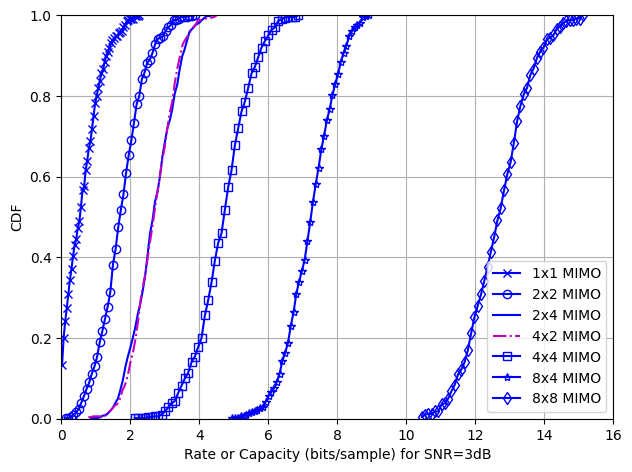

In [11]:
# Now ready to plot the CDF of the capacity distribution
plt.plot(C11,np.cumsum(N11)/K,'b-x',label='1x1 MIMO',mfc='none')
plt.plot(C22,np.cumsum(N22)/K,'b-o',label='2x2 MIMO',mfc='none')
plt.plot(C24,np.cumsum(N24)/K,'b-',label='2x4 MIMO',mfc='none')
plt.plot(C42,np.cumsum(N42)/K,'m-.',label='4x2 MIMO',mfc='none')
plt.plot(C44,np.cumsum(N44)/K,'b-s',label='4x4 MIMO',mfc='none')
plt.plot(C84,np.cumsum(N84)/K,'b-*',label='8x4 MIMO',mfc='none')
plt.plot(C88,np.cumsum(N88)/K,'b-d',label='8x8 MIMO',mfc='none')
plt.legend(loc='lower right'); plt.grid(); plt.ylim([0,1]); plt.xlim([0,16])
plt.xlabel('Rate or Capacity (bits/sample) for SNR=3dB'); plt.ylabel('CDF')
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig12_15.png" width="600" />

<center><b>Figure 12.15</b> Cumulative distribution function (CDF) of different MIMO configurations.</center>